Date: Jan 27 2025

Classification models for Project 1

Version 2

In [ ]:
#Imports
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from itertools import combinations
from datetime import datetime

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from hyperopt import fmin, tpe,rand, hp, STATUS_OK,space_eval
from hyperopt.pyll.base import scope

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.naive_bayes import BernoulliNB

from xgboost import plot_importance
from xgboost import plot_tree
#import shap


In [ ]:
# Try a few seeds
# Recursive Feature Elimination
# HyperOpt
# Ensemble models -> stacking and voting (must choose a set of estimators) May not give better performance compared to single models. But just try them out.
# Then, select one model (to wrap up the project)

In [ ]:
#Load the data
df = pd.read_csv("ACME-HappinessSurvey2020.csv")
df.head()

In [ ]:
import random

#seed = random.randint(1000, 9999)
seed = 2851#1311 #3717#7739 , 4964, 3717 (best, good recall AND precision), | 3874, 8013 (best acc for bernoulli NB) | 1311 (best for LGBM)
print(seed)



In [ ]:
features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
X = df[features]
Y = df['Y']

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Print the shapes of the resulting sets
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

In [ ]:

def recall_func(y_test, y_pred):
    return recall_score(y_test, y_pred, pos_label=0)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from collections import defaultdict, Counter

# Number of iterations
num_iterations = 50

# Dictionary to store top 10 models per iteration
top_models_per_iteration = []

# Dictionary to store best accuracy and corresponding seed for each model
best_seeds = defaultdict(lambda: (0, None))

for _ in range(num_iterations):
    # Split data with different random seed
    seed = random.randint(1000, 9999)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
    
    # Initialize LazyClassifier
    clf = LazyClassifier(verbose=0, predictions=False,ignore_warnings=True, custom_metric=recall_func,)
    
    # Fit and evaluate models
    models, _ = clf.fit(x_train, x_test, y_train, y_test)
    
    # Get top 10 models for this iteration
    top_10_models = models.head(5).index.tolist()
    top_models_per_iteration.extend(top_10_models)
    
    # Record best accuracy and corresponding seed
    for model_name, row in models.iterrows():
        accuracy = row['recall_func']
        if accuracy > best_seeds[model_name][0]:
            best_seeds[model_name] = (accuracy, seed)

# Count occurrences of each model in the top 10
model_counts = Counter(top_models_per_iteration)

# Get the three most frequently appearing models
best_models = model_counts.most_common(3)

# Display results
print("Top 3 Most Frequently Appearing Models in Top 5:")
for model, count in best_models:
    best_accuracy, best_seed = best_seeds[model]
    print(f"{model}: {count} times, Best Accuracy: {best_accuracy:.4f}, Best Seed: {best_seed}")


In [ ]:
# Baselines
# LazyClassifier runs all models using their default settings. 
# Use this to get a sense of the top performing models and then finetune them.
# We are more interested predicting the unhappy class (class 0) correctly. So, we make it the positive class.
# We should improve recall. So, we select the best models based on recall. 
# F1 score is a combination of recall and precision. 


clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=recall_func, predictions=True, random_state=seed)
models,predictions = clf.fit(x_train, x_test, y_train, y_test)

models

In [ ]:
# Scaling the features and fitting the models.
# Scaling does not change the results.

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
x_train_scaled, x_test_scaled, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

# Print the shapes of the resulting sets
print(x_train_scaled.shape, x_test_scaled.shape, y_train.shape, y_test.shape)

# Baselines
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=recall_func, predictions=True)
models,predictions = clf.fit(x_train_scaled, x_test_scaled, y_train, y_test)

models

In [ ]:
# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)

### Notes on selected classifiers

1. XGBoost (Extreme gradient boosting)

    Highly optimized gradient boosting using decision trees as weak learners.

Gini impurity - Used by tree classifiers to decide the best split at each node. The split with the lowest impurity is chosen. 
Feature importance - The amount by which a feature decreases the Gini impurity at each node. The higher the better. 

In [ ]:
# sklearn BaggingClassifier does not have feature importance function.
# So, a wrapper for BaggingClassifier was created.
class MyBaggingClassifier(BaggingClassifier):
    @property
    def feature_importances_(self):
        feature_importances = np.mean([
            tree.feature_importances_ for tree in self.estimators_], axis=0)
        
        return feature_importances



   Accuracy  Recall  Precision
0      0.58    0.67       0.53
1      0.65    1.00       0.57
2      0.62    0.75       0.56


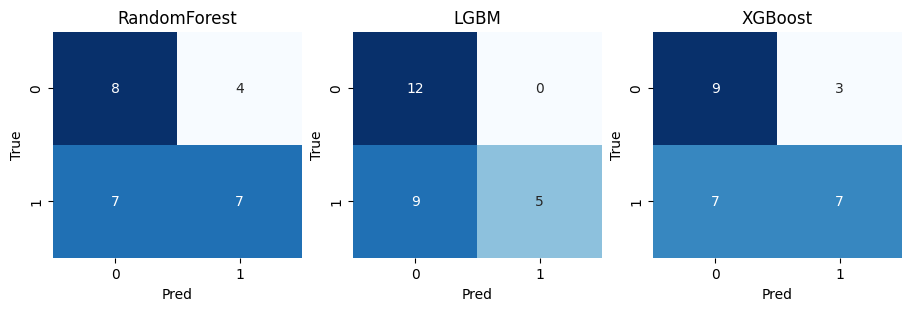

In [58]:
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'LGBM': LGBMClassifier(num_leaves=3), #random_state=seed
    'XGBoost': XGBClassifier()
}

fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)

metrics = []
importances = []

for idx, (clf_name, clf) in enumerate(classifiers.items()):

    clf.fit(x_train, y_train) #clf.fit(x_train, y_train, eval_set=[(x_test, y_test)]) #(eval_set for early stopping)

    # Make predictions
    y_pred = clf.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred,normalize=True)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)

    metrics.append([accuracy, recall, precision])

    #importances.append(clf.feature_importances_)

    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])

# importance_df = pd.DataFrame(
#     {
#         'Features': features,
#         'NaiveBayes': importances[0],
#         'LGBM': importances[1],
#         'XGBoost': importances[2]
#     }
# )
print(metrics_df)
#print(importance_df)
plt.show()

When looking at the importance values, X1 shows the highest importance for all three classifiers, but other feature importances don't show a pattern among the classifiers.

What other ways to see how each feature contribute to the model performance? Since the dataset is small, we can do an exhaustive search of all feature combinations.

In [ ]:
## Feature-wise classification
results = {clf_name:[] for clf_name in classifiers.keys()}

for idx, (clf_name, clf) in enumerate(classifiers.items()):
    best_combinations = []
    for i in range(1, len(features)+1):
        for combo in combinations(features, i):
            X_subset = df[list(combo)]
            x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)
            clf.fit(x_train_subset, y_train)

            # Make predictions
            y_pred = clf.predict(x_test_subset)
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, pos_label=0)
            recall = recall_score(y_test, y_pred, pos_label=0)

            best_combinations.append((combo, accuracy, recall, precision))
    
    best_combinations.sort(key=lambda x:x[2], reverse=True)
    results[clf_name] = best_combinations[:3]

final_result = []

for clf_name, top_combos in results.items():
    for combo, acc, recall, precision in top_combos:
        final_result.append({'Classifier':clf_name, 'Features':combo, 'Accuracy':acc, 'Precision':precision, 'Recall':recall})

final_df = pd.DataFrame(final_result)
print(final_df)
            
        

(X1, X3, X4, X6) combination is common to all three models.

In [ ]:
## Confusion matrices for selected combination

features_subset = ['X1', 'X3', 'X4', 'X5'] # Common feature set for all three models
X_subset = df[features_subset]
x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)

metrics = []
importances = []

for idx, (clf_name, clf) in enumerate(classifiers.items()):

    clf.fit(x_train_subset, y_train) #clf.fit(x_train, y_train, eval_set=[(x_test, y_test)]) #(eval_set for early stopping)

    # Make predictions
    y_pred = clf.predict(x_test_subset)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)

    metrics.append([accuracy, recall, precision])

   # importances.append(clf.feature_importances_)

    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)

Decision tree gives the highest recall and accuracy.
XGBoost and ExtraTrees are ensemble models. They could be overfitting. Especially when some features are removed. 

In [ ]:
## Check overfitting using ROC curves

features_subset = ['X1', 'X3', 'X4', 'X5'] # Common feature set for all three models
X_subset = df[features_subset]
x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)

for idx, (clf_name, clf) in enumerate(classifiers.items()):
    
    clf.fit(x_train_subset, y_train)

    y_probs_train = clf.predict_proba(x_train_subset)[:,0] # Positive class is 0
    y_probs_test = clf.predict_proba(x_test_subset)[:,0] # Positive class is 0

    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_probs_train, pos_label=0)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_probs_test, pos_label=0)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    ax[idx].plot(fpr_train, tpr_train, 'b', label='Train AUC = {:0.2f}'.format(roc_auc_train))
    ax[idx].plot(fpr_test, tpr_test, 'r', label='Test AUC = {:0.2f}'.format(roc_auc_test))
    ax[idx].legend()
    ax[idx].set_title(clf_name)
    ax[idx].set_xlabel('FPR')
    ax[idx].set_ylabel('TPR')

plt.show()


Overfitting is somewhat evident for XGBoost, but not for ExtraTrees. 
We need to finetune the models to reduce overfitting.
We can use `GridSearchCV` (exhaustively looking at all hyperparameter combinations) here because the dataset is small. If the dataset is large, we can use `RandomSearch`.
Note that this is automated hyperparameter tuning. So, cross validation is used here. Cross-validation DOES NOT train the model. It is used to evaluate the current model by fitting the model on part of the training data and VALIDATING on the other part. After validating, if the performance is satisfactory, we fit the model on the entire training set and test on the test partition.

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:

def my_scorer(estimator, x, y):
    
    y_pred = estimator.predict(x)
    score = recall_score(y, y_pred, pos_label=0)

    return score

In [ ]:
# ## Finetuning XGBoost to reduce overfitting


# features_subset = ['X1', 'X3', 'X4', 'X6'] # Common feature set for all three models
# X_subset = df[features_subset]
# x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

# # A parameter grid for XGBoost
# params = {
#         'min_child_weight': [1, 5, 10], #Larger -> more conservative model (i.e. less splitting)
#         'gamma': [0, 0.5, 1, 1.5, 2, 5], #Larger -> more conservative model (i.e. less splitting)
#         'max_depth': [3, 4, 5, 6] #Smaller -> mpre conservative model
#         }

# skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = seed)
# kf = KFold(n_splits=10, shuffle = True, random_state = seed)

# grid = GridSearchCV(estimator=classifiers['Bagging'], param_grid=params, scoring=my_scorer, n_jobs=4, cv=kf.split(x_train_subset,y_train), verbose=3, error_score='raise')

# starttime = timer()
# grid.fit(x_train_subset, y_train)
# timer(starttime)

# print('\n All results:')
# print(grid.cv_results_)
# print('\n Best estimator:')
# print(grid.best_estimator_)
# print('\n Best score:')
# print(grid.best_score_ )#print(grid.best_score_ * 2 - 1)
# print('\n Best parameters:')
# print(grid.best_params_)
# results = pd.DataFrame(grid.cv_results_)
# results.to_csv('xgb-grid-search-results-01.csv', index=False)

# y_pred = grid.best_estimator_.predict(x_test_subset)
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, pos_label=0)
# recall = recall_score(y_test, y_pred, pos_label=0)

# print(f'Accuracy = {accuracy:0.2f}, Precision = {precision:0.2f}, Recall = {recall:0.2f}')

# # y_test = grid.best_estimator_.predict_proba(x_test_subset)
# # results_df = pd.DataFrame(data={'id':test_df['id'], 'target':y_test[:,1]})
# # results_df.to_csv('submission-grid-search-xgb-porto-01.csv', index=False)



In [ ]:

#clf = XGBClassifier(random_state=seed, gamma = 0.5, max_depth = 3, min_child_weight = 5)
#clf = XGBClassifier(random_state=seed, gamma = 0, max_depth = 6, min_child_weight = 1)
clf = LGBMClassifier(num_leaves=4, n_estimators=3, min_data_in_leaf=1, verbose=0)

# Create a KFold object
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

# Perform cross-validation
#scores = cross_val_score(grid.best_estimator_, x_train_subset, y_train, cv=kfold, scoring=my_scorer)
scores = cross_val_score(clf, x_train, y_train, cv=kfold, scoring=my_scorer)

# Print the scores
print(scores)

# Calculate the mean score
print(scores.mean())

clf.fit(x_train, y_train)

y_pred = clf.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)


fig, ax = plt.subplots()
cm = confusion_matrix(y_test, y_pred)
s = sns.heatmap(cm, ax = ax, cbar = False, annot=True, cmap='Blues')
s.set_xlabel('Pred')
s.set_ylabel('True')
s.set_title(clf_name)

print(f'Accuracy = {accuracy:0.2f}, Precision = {precision:0.2f}, Recall = {recall:0.2f}')
plt.show()

GridSearchCV does not give the best test scores. Default settings give better test scores. But, train cross validation scores vary largely and they are higher for the hyperparameters given by the grid search.
High variability of cross validation scores and descrepancy between train and test scores could be because the model has not been fit well or the training set is not generalizing well. 

In [ ]:
# Initialize StratifiedKFold for maintaining class distribution in each fold
#skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
#kf = KFold(n_splits=10, shuffle=True, random_state=seed)
# Visualize the distributions
# fold_number = 1
# for train_index, test_index in kf.split(x_train_subset, y_train):
#     fold_df = df.iloc[test_index]
    
#     # Plot class distribution
#     plt.figure(figsize=(10, 4))
    
#     plt.subplot(1, 2, 1)
#     sns.countplot(x='Y', data=fold_df)
#     plt.title(f'Class Distribution - Fold {fold_number}')
#     plt.xlabel('Class')
#     plt.ylabel('Count')
    
#     # Plot feature distribution (for the first feature as an example)
#     plt.subplot(1, 2, 2)
#     sns.histplot(fold_df['X3'], kde=True, bins=10)
#     plt.title(f'Feature Distribution (X3) - Fold {fold_number}')
#     plt.xlabel('Feature Value')
#     plt.ylabel('Count')
    
#     plt.tight_layout()
#     plt.show()
    
#     fold_number += 1

In [ ]:
os.environ["PATH"] += os.pathsep + 'D:/Installations/Graphviz-12.2.1-win64/bin/'

In [ ]:
# Play around with the random seed (42 may not give the best results)
# Recursive feature elemination (RFE)
# HyperOPT - SOTA in hyperparameter tuning
# Ensemble models - stacking and voting 
# Select one model

In [59]:
# Use a base classifier for RFE
# model = RandomForestClassifier()
# rfe = RFE(model, n_features_to_select=2)  # Adjust the number of features to select
# rfe.fit(X, y)

# Print ranking of features
# print(f"Feature Ranking: {dict(zip(features, rfe.ranking_))}")

## Feature-wise classification
results = {clf_name:[] for clf_name in classifiers.keys()}

for idx, (clf_name, clf) in enumerate(classifiers.items()):
    rfe = RFE(clf, n_features_to_select=4)  # Adjust the number of features to select
    rfe.fit(x_train, y_train)

    # Print ranking of features
    #print(f"Feature Ranking ({clf_name}): {dict(zip(features, rfe.ranking_))}")
    ranking = pd.DataFrame({'Feature': features, 'Ranking': rfe.ranking_})
    print(f"{clf_name} \n {ranking}")
            

RandomForest 
   Feature  Ranking
0      X1        2
1      X2        1
2      X3        1
3      X4        1
4      X5        1
5      X6        3
LGBM 
   Feature  Ranking
0      X1        1
1      X2        2
2      X3        1
3      X4        3
4      X5        1
5      X6        1
XGBoost 
   Feature  Ranking
0      X1        1
1      X2        3
2      X3        1
3      X4        2
4      X5        1
5      X6        1


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

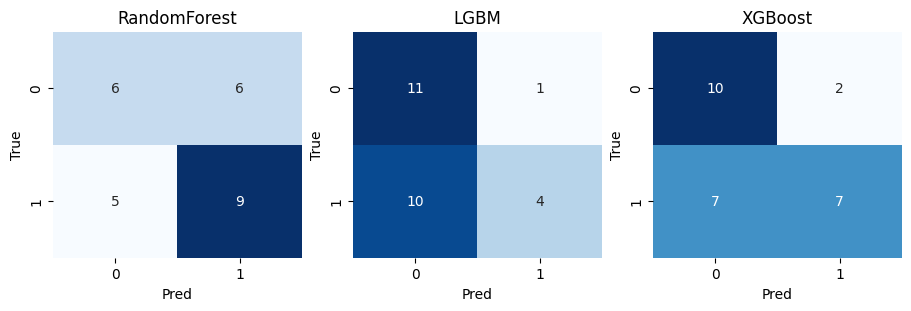

In [ ]:
## Confusion matrices for selected combination

classifiers = {
    'RandomForest': RandomForestClassifier(random_state=seed),
    'LGBM': LGBMClassifier(random_state=seed), #random_state=seed n_estimators=8, min_data_in_leaf=0
    'XGBoost': XGBClassifier(random_state=seed)
}

features_subset = [['X2', 'X3', 'X4', 'X5'],
                   ['X1', 'X3', 'X5', 'X6'],
                    ['X1', 'X3', 'X5', 'X6']] # Common feature set for all three models
fig, ax = plt.subplots(1, 3, figsize=(9,3), constrained_layout=True)
metrics = []
importances = []
for idx, (clf_name, clf) in enumerate(classifiers.items()): 
    X_subset = df[features_subset[idx]]
    x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

    clf.fit(x_train_subset, y_train) #clf.fit(x_train, y_train, eval_set=[(x_test, y_test)]) #(eval_set for early stopping)

    # Make predictions
    y_pred = clf.predict(x_test_subset)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=0)
    recall = recall_score(y_test, y_pred, pos_label=0)

    metrics.append([accuracy, recall, precision])

    # importances.append(clf.feature_importances_)

    cm = confusion_matrix(y_test, y_pred)
    s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
    s.set_xlabel('Pred')
    s.set_ylabel('True')
    s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)

In [ ]:
import os, sys
os.path.dirname(sys.executable)

In [64]:
# LGBM optimization with HyperOpt

X_subset = df[features_subset[1]]
x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

# Define the objective function
def objective(params):
    #print(f"Trying params: {params}")
    model = LGBMClassifier(**params, verbose=-1)
    score = cross_val_score(model, x_train_subset, y_train, cv=3, scoring=my_scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}

# Define the search space
space = {
    'num_leaves': scope.int(hp.quniform('num_leaves', 2, 32, 2)),  # Small range to avoid overfitting
    'min_data_in_leaf': scope.int(hp.quniform('min_data_in_leaf', 5, 50, 5)),  # Prevent too small leaves
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # 0.001 to 1.0
    'max_depth': hp.choice('max_depth', [-1, 3, 5, 7]),  # Limit depth for small dataset
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Feature selection
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Row sampling for regularization
    'reg_alpha': hp.loguniform('reg_alpha', -4, 1),  # L1 regularization (0.0001 to 10)
    'reg_lambda': hp.loguniform('reg_lambda', -4, 1),  # L2 regularization (0.0001 to 10)
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 10)),  # Limit estimators for small dataset
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart', 'rf']),  # Try both methods
}

# Run the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=500)

# Print the best hyperparameters
best_params = space_eval(space, best_params)
print("Best hyperparameters:", best_params)


# Evaluate the model with the best hyperparameters
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['min_data_in_leaf'] = int(best_params['min_data_in_leaf'])
best_params['n_estimators'] = int(best_params['n_estimators'])

final_model = LGBMClassifier(**best_params, random_state=seed)
final_model.fit(x_train_subset, y_train)
# accuracy = final_model.score(x_test_subset,y_test)
# print("Accuracy:", accuracy)

y_pred = clf.predict(x_test_subset)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label=0)
recall = recall_score(y_test, y_pred, pos_label=0)
metrics = []
metrics.append([accuracy, recall, precision])

# importances.append(clf.feature_importances_)

cm = confusion_matrix(y_test, y_pred)
s = sns.heatmap(cm, ax = ax[idx], cbar = False, annot=True, cmap='Blues')
s.set_xlabel('Pred')
s.set_ylabel('True')
s.set_title(clf_name)

metrics_df = pd.DataFrame(metrics, columns=['Accuracy', 'Recall', 'Precision'])
print(metrics_df)


100%|██████████| 500/500 [00:55<00:00,  8.96trial/s, best loss: -1.0]              
Best hyperparameters: {'boosting_type': 'rf', 'colsample_bytree': 0.8574169608312157, 'learning_rate': 0.08137210859279474, 'max_depth': 7, 'min_data_in_leaf': 35, 'n_estimators': 290, 'num_leaves': 26, 'reg_alpha': 0.6550304486011378, 'reg_lambda': 0.3749302997561087, 'subsample': 0.6993777723871315}
   Accuracy  Recall  Precision
0      0.65    0.83       0.59


In [68]:
# XGBoost optimization with HyperOpt

X_subset = df[features_subset[1]]
x_train_subset, x_test_subset, y_train, y_test = train_test_split(X_subset, Y, test_size=0.2, random_state=seed)

# Define the objective function
def objective(params):
    #print(f"Trying params: {params}")
    model = XGBClassifier(**params, verbose=-1)
    score = cross_val_score(model, x_train_subset, y_train, cv=3, scoring=my_scorer).mean()
    return {'loss': -score, 'status': STATUS_OK}

search_space = {
    'learning_rate': hp.loguniform('learning_rate', -4, 0),  # ~0.0001 to 1
    'max_depth': hp.choice('max_depth', [2, 3, 4, 5, 6, 7, 8, 9]),  # Integer selection
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 10)),  # Integer 50-300 in steps of 10
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Use 50-100% of data per round
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),  # Use 50-100% of features per tree
    'gamma': hp.loguniform('gamma', -5, 1),  # ~0.0067 to 2.71
    'reg_alpha': hp.loguniform('reg_alpha', -5, 1),  # L1 regularization ~0.0067 to 2.71
    'reg_lambda': hp.loguniform('reg_lambda', -5, 2),  # L2 regularization ~0.0067 to 7.39
}

# Run the optimization
best_params = fmin(objective, space, algo=tpe.suggest, max_evals=500)

# Print the best hyperparameters
best_params = space_eval(space, best_params)
print("Best hyperparameters:", best_params)

# Evaluate the model with the best hyperparameters
best_params['n_estimators'] = int(best_params['n_estimators'])

final_model = XGBClassifier(**best_params, random_state=seed)
final_model.fit(x_train_subset, y_train)
accuracy = final_model.score(x_test_subset,y_test)
print("Accuracy:", accuracy)

  0%|          | 0/500 [00:00<?, ?trial/s, best loss=?]

  1%|          | 3/500 [00:00<01:57,  4.22trial/s, best loss: -0.5333333333333333]

job exception: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Installations\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Installations\Python\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "d:\Installations\Python\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "d:\Installations\Python\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "d:\Installations\Python\Lib\site-packages\xg

  1%|          | 3/500 [00:00<02:04,  3.99trial/s, best loss: -0.5333333333333333]


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Installations\Python\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Installations\Python\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "d:\Installations\Python\Lib\site-packages\xgboost\sklearn.py", line 1531, in fit
    self._Booster = train(
                    ^^^^^^
  File "d:\Installations\Python\Lib\site-packages\xgboost\core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "d:\Installations\Python\Lib\site-packages\xgboost\training.py", line 181, in train
    bst.update(dtrain, iteration=i, fobj=obj)
  File "d:\Installations\Python\Lib\site-packages\xgboost\core.py", line 2100, in update
    _check_call(
  File "d:\Installations\Python\Lib\site-packages\xgboost\core.py", line 284, in _check_call
    raise XGBoostError(py_str(_LIB.XGBGetLastError()))
xgboost.core.XGBoostError: value -1 for Parameter max_depth should be greater equal to 0
max_depth: Maximum depth of the tree; 0 indicates no limit; a limit is required for depthwise policy


In [ ]:
final_model.estimator_.get_params()